In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import os
data_folder = '../data/'


# 9: SARIMA Model

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [9]:
#Catfish Sales Data
catfish_sales = pd.read_csv(os.path.join(data_folder, 'catfish.csv'),
                            parse_dates=['Date'], index_col='Date'
                            )
catfish_sales.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [11]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [12]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

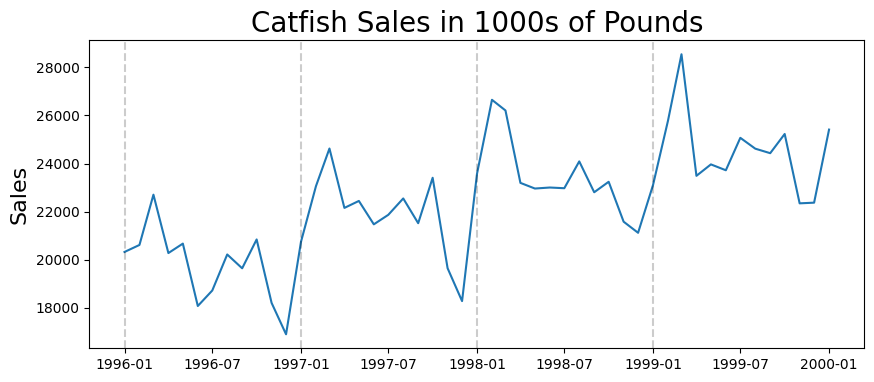

In [13]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [14]:
first_diff = lim_catfish_sales.diff()[1:]

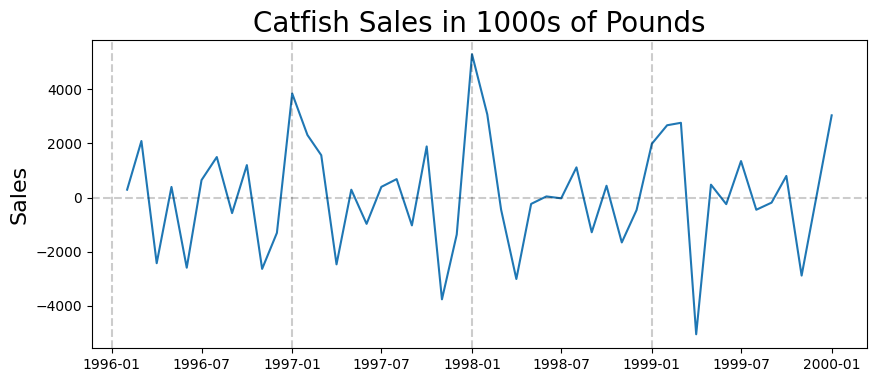

In [15]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

<BarContainer object of 17 artists>

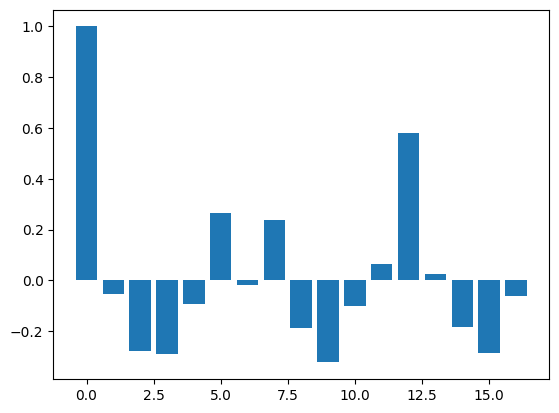

In [29]:
acf_vals = acf(first_diff)
num_lags = min(20, len(acf_vals))
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

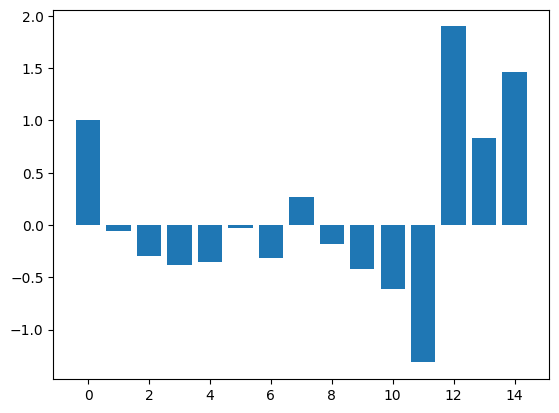

In [30]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [31]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [32]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [33]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87298D+00    |proj g|=  1.21940D+00

At iterate    5    f=  8.58382D+00    |proj g|=  3.02862D-01

At iterate   10    f=  8.55722D+00    |proj g|=  1.37619D-03

At iterate   15    f=  8.55722D+00    |proj g|=  1.04073D-03

At iterate   20    f=  8.55706D+00    |proj g|=  2.63664D-02

At iterate   25    f=  8.53842D+00    |proj g|=  1.19055D-01

At iterate   30    f=  8.50954D+00    |proj g|=  1.09968D-01

At iterate   35    f=  8.50313D+00    |proj g|=  6.47363D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [34]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Wed, 22 Mar 2023   AIC                            737.269
Time:                                      13:04:46   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [42]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data.squeeze() - predictions.squeeze()

Text(0, 0.5, 'Error')

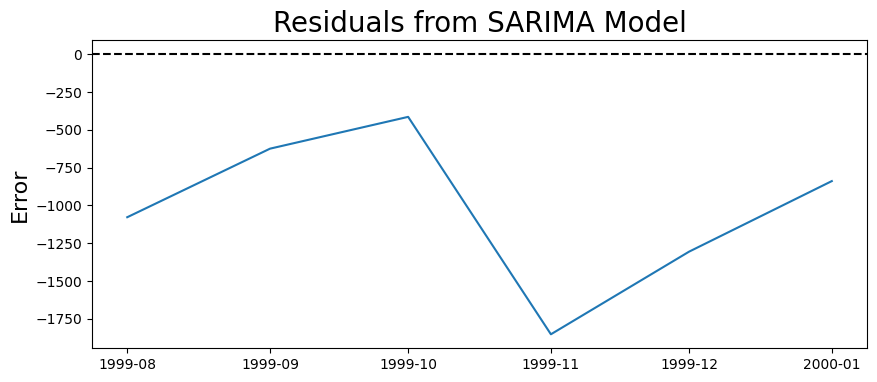

In [43]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

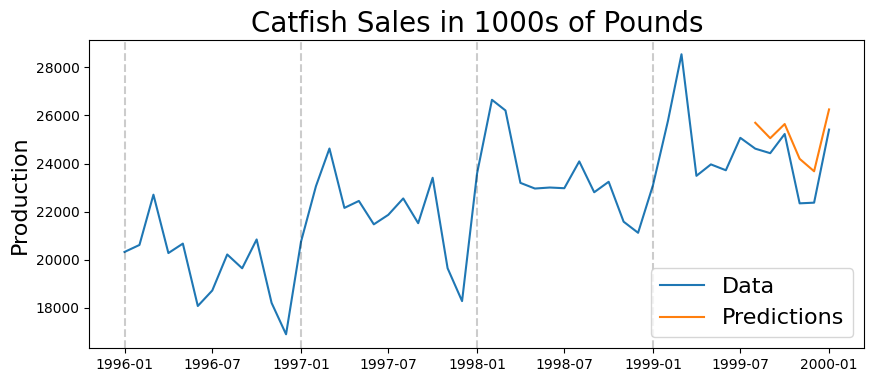

In [44]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [47]:
test_data\
    .shape

(6, 1)

In [48]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.squeeze())),4))

Mean Absolute Percent Error: 0.0433


In [49]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.3056943982156


# Using the Rolling Forecast Origin

In [61]:
rolling_predictions = test_data.squeeze().copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87298D+00    |proj g|=  1.21940D+00

At iterate    5    f=  8.58382D+00    |proj g|=  3.02862D-01

At iterate   10    f=  8.55722D+00    |proj g|=  1.37619D-03

At iterate   15    f=  8.55722D+00    |proj g|=  1.04073D-03

At iterate   20    f=  8.55706D+00    |proj g|=  2.63664D-02

At iterate   25    f=  8.53842D+00    |proj g|=  1.19055D-01

At iterate   30    f=  8.50954D+00    |proj g|=  1.09968D-01

At iterate   35    f=  8.50313D+00    |proj g|=  6.47363D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarim


At iterate   10    f=  8.53521D+00    |proj g|=  1.26069D-03

At iterate   15    f=  8.53521D+00    |proj g|=  1.24035D-03

At iterate   20    f=  8.53507D+00    |proj g|=  1.47441D-02

At iterate   25    f=  8.52406D+00    |proj g|=  8.24832D-02

At iterate   30    f=  8.50492D+00    |proj g|=  6.77856D-02

At iterate   35    f=  8.49450D+00    |proj g|=  1.54197D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     59      1     0     0   1.504D-05   8.494D+00
  F =   8.4942658984964972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarim


At iterate    5    f=  8.52124D+00    |proj g|=  1.34321D-01

At iterate   10    f=  8.50097D+00    |proj g|=  1.43343D-03

At iterate   15    f=  8.50096D+00    |proj g|=  3.70428D-04

At iterate   20    f=  8.50084D+00    |proj g|=  3.94992D-03

At iterate   25    f=  8.49494D+00    |proj g|=  2.13762D-02

At iterate   30    f=  8.48986D+00    |proj g|=  1.55626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     38      1     0     0   2.780D-05   8.490D+00
  F =   8.4898467447992996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

In [64]:
rolling_residuals = test_data.squeeze() - rolling_predictions.squeeze()

Text(0, 0.5, 'Error')

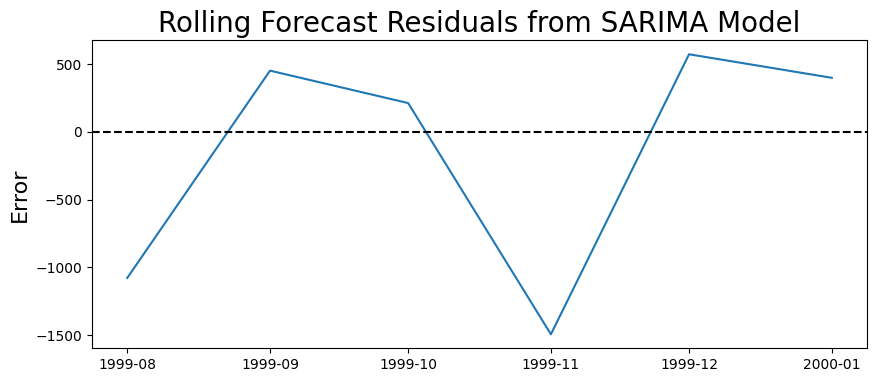

In [66]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

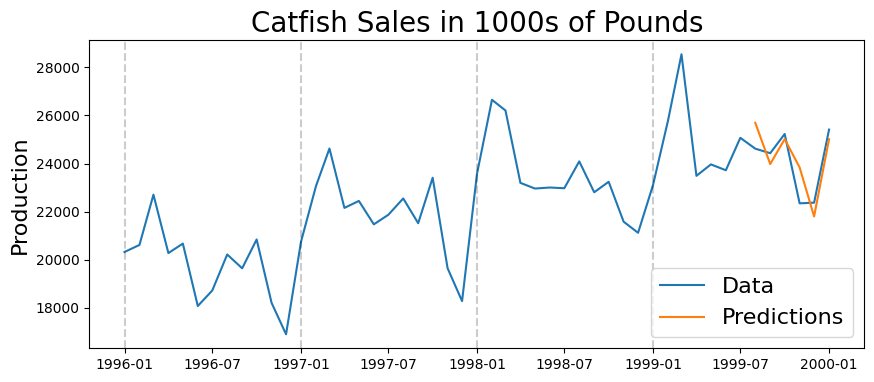

In [67]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [70]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data.squeeze())),4))

Mean Absolute Percent Error: 0.0298


In [69]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 829.3411406660159
